Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])
Shape of the samples: torch.Size([10000, 2]) torch.Size([10000, 2])
--------------------------------------------------
model load success
--------------------------------------------------


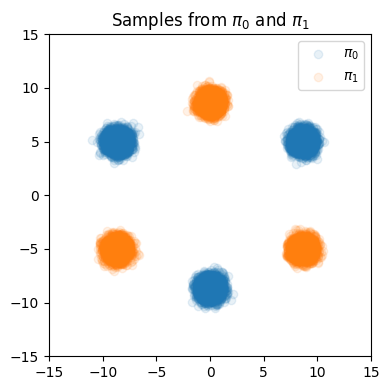

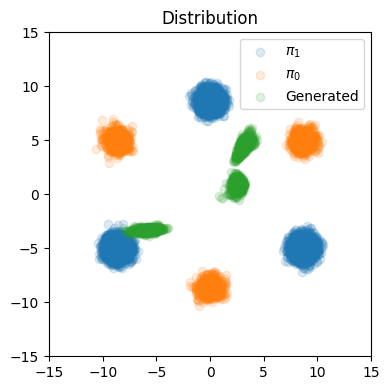

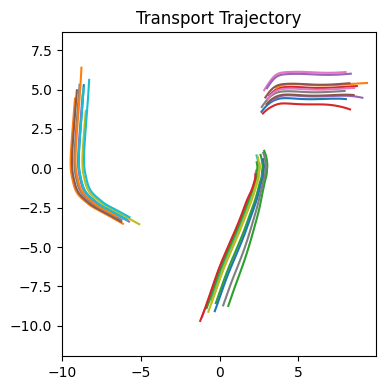

In [1]:

import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import wandb
import os
from second_order_code import MLP, MLP_2nd_order, RectifiedFlow

D = 10.
M = D+5
VAR = 0.3
DOT_SIZE = 4
COMP = 3

initial_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
initial_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., D / 2.], [-D * np.sqrt(3) / 2., D / 2.], [0.0, - D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
initial_model = MixtureSameFamily(initial_mix, initial_comp)
samples_0 = initial_model.sample([10000])
target_mix = Categorical(torch.tensor([1/COMP for i in range(COMP)]))
target_comp = MultivariateNormal(torch.tensor([[D * np.sqrt(3) / 2., - D / 2.], [-D * np.sqrt(3) / 2., - D / 2.], [0.0, D * np.sqrt(3) / 2.]]).float(), VAR * torch.stack([torch.eye(2) for i in range(COMP)]))
target_model = MixtureSameFamily(target_mix, target_comp)
samples_1 = target_model.sample([10000])
print('Shape of the samples:', samples_0.shape, samples_1.shape)

wandb_log_name = "second_order_v2"
ckpt_dir = "checkpoints"
input_dim = 2


rectified_flow_1 = RectifiedFlow(first_order_model=MLP(input_dim, hidden_num=100), second_order_model=MLP_2nd_order(input_dim, hidden_num=100), num_steps=100)

save_dir = os.path.join(ckpt_dir, wandb_log_name)
first_order_model_save_path = os.path.join(save_dir, 'first_order_model.pt')
second_order_model_save_path = os.path.join(save_dir, 'second_order_model.pt')
rectified_flow_1.first_order_model.load_state_dict(torch.load(first_order_model_save_path))
rectified_flow_1.second_order_model.load_state_dict(torch.load(second_order_model_save_path))

print("-" * 50)
print("model load success")
print("-" * 50)


@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)
#   traj = sample_ode_with_model(rectified_flow, z0=z0, N=N)

#   print(len(traj))

  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)

#   print(traj[0][:, 1].cpu().numpy())
#   raise

  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()
  fig_save_path = os.path.join("images", f"{wandb_log_name}_gen_scatters.png")
  plt.savefig(fig_save_path)

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(30):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

  # savefigs
  fig_save_path = os.path.join("images", f"{wandb_log_name}_trajectory.png")
  plt.savefig(fig_save_path)

#   plt.save(f"{wandb_log_name}.png")

draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=100)



